In [1]:
import pandas as pd, numpy as np, holidays, seaborn as sns, matplotlib.pyplot as plt, time, xgboost as xgb
from sqlalchemy import create_engine
from datetime import datetime
from matplotlib import pyplot

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from config import config

<h1>Modelling Evaluation & Validation</h1>
<br>
<div>In this workbook, we perform all steps up to modelling in accordance with the feature selection and hyperparameter tuning notebook. In the modelling section, we pit the best hyperparameter configurations we learned from said notebook for a Multi-layer Perceptron, Random Forest Regressor, Polynomial Regressor and Extreme Gradient Booster against each other and compare their 5-fold cross validated performance. The training time and performance result is evaluated to choose the model for deployment.</div>

<h2>Data Collection</h2>

In [2]:
#establish connection to db and retrieve data
config=config()
engine=create_engine("postgresql://"+config["user"]+":"+config["password"]+"@"+config["host"]+"/"+config["database"])
line='15A'
direction=1
sql=("SELECT lt.daystamp, lt.progr_number, lt.stoppoint_id,lt.arrival_time_p,lt.arrival_time_a,"
    "lt.departure_time_p,lt.departure_time_a,trips.route_id,"
     "trips.arrival_time_p,trips.departure_time_p,trips.departure_time_a,"
     "weather_main,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_description "
     "FROM leavetimes AS lt, trips, weather "
     "WHERE trips.line_id='"+line+"' AND trips.direction="+str(direction)+" AND trips.suppressed=0 "
     "AND lt.daystamp = trips.daystamp AND lt.trip_id = trips.trip_id AND lt.suppressed=0"
     "AND lt.weather_id = weather.daytime")
df = pd.read_sql(sql,engine)

In [3]:
#renames the features of the dataframe
features=list(df.columns)
features[0]="daystamp"
features[2]="stop_id"
features[3]="arr_p"
features[4]="arr_a"
features[5]="dep_p"
features[6]="dep_a"
features[8]="end_p"
features[9]="start_p"
features[10]="start_a"
df.columns=features

In [4]:
holidays_IE=holidays.Ireland()
def daystamp_converter(time):
    """extracts and returns tuple of (weekday,month,hour,holiday) from datetime object."""
    date=datetime.fromtimestamp(time)
    if date in holidays_IE:
        holiday=1
    else:
        holiday=0
    return (date.weekday(),date.month,date.hour,holiday)

In [5]:
#convert time specific data from the dataframe
df["dt"]=df.daystamp.values+df.dep_p.values
df["weekday"],df["month"],df["hour"],df["holiday"]=zip(*df['dt'].apply(daystamp_converter))
df["dur_s"]=df.dep_p.values-df.start_p.values
df["dur_a"]=df.dep_a.values-df.start_a.values

<h2>Feature Cleaning</h2>

In [6]:
#create log dict
logs={
    "rows":{
        "start":df.shape[0]
    }
}

In [7]:
#filter out uncommon routes
routes=df.route_id.value_counts().index[0]
df_clean=df[df.route_id==routes]
rows_routes=df_clean.shape[0]
logs["rows"]["route_filter"]=rows_routes-logs["rows"]["start"]

In [8]:
#remove null values
df_clean = df_clean.dropna(axis = 0, how ='any') 
rows_after_nan=df_clean.shape[0]
logs["rows"]["nan_filter"]=rows_after_nan-rows_routes

In [9]:
#calculate ratio of least to most visited stop
stop_counts=df_clean.stop_id.value_counts()
logs["scr"]=min(stop_counts)/max(stop_counts)

In [10]:
#assign features to type
categorical=["stop_id","route_id","weather_main","weather_description","weekday","month","hour","holiday"]
df_clean[categorical]=df_clean[categorical].astype("category")
ints=['daystamp','progr_number','arr_p','arr_a','dep_p','dep_a','dur_s','dur_a','pressure','humidity','wind_deg','clouds_all']
floats=['temp','feels_like','temp_min','temp_max','wind_speed']

In [11]:
#clean up dataframe
df_clean=df_clean.drop(["route_id"],axis=1)
df_clean[ints]=df_clean[ints].astype('int64')
df_clean=df_clean[df_clean.dur_a>=0]
rows_after_dur=df_clean.shape[0]
logs["rows"]["negative_dur"]=rows_after_dur-rows_after_nan
df_clean=df_clean.drop(["stop_id"],axis=1)

In [12]:
#create dataframe with means and standard deviations per progr_number
dur_stats_df=pd.DataFrame(columns=["progr_number","dur_mean","dur_std"])
for progr_number in df_clean.progr_number.unique():
    durations=df_clean.dur_a[df_clean["progr_number"]==progr_number]
    dur_stats_df=dur_stats_df.append(pd.Series([progr_number,durations.mean(),durations.std()],index=dur_stats_df.columns),ignore_index=True)
    dur_stats_df["progr_number"]=dur_stats_df["progr_number"].astype('int64')

#merge duration stats with df_clean and look for outliers (outside 3 SDs from mean)
df_clean=df_clean.merge(dur_stats_df,how='inner',on='progr_number')
df_clean["outlier"]=abs(df_clean["dur_a"]-df_clean["dur_mean"])>3*df_clean["dur_std"]

#only keep rows that aren't outliers
df_clean=df_clean[df_clean["outlier"]==False]
rows_after_outliers=df_clean.shape[0]
logs["rows"]["outliers"]=rows_after_outliers-rows_after_dur

#remove stat columns from dataframe
df_clean=df_clean.drop(["dur_mean","dur_std","outlier"],axis=1)

In [13]:
#add statistics of means and std to logs
logs["stats"]=dur_stats_df.set_index("progr_number").to_dict("index")

<h2>Feature Selection</h2>

In [14]:
#determine best feature combinations
y=df_clean["dur_a"]
X=df_clean.drop(["dur_a"],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
categorical=X_train.columns[X_train.dtypes=="category"]
X_train_enc=pd.get_dummies(X_train[categorical],drop_first=True)
X_test_enc=pd.get_dummies(X_test[categorical],drop_first=True)
dummy_columns=list(X_train_enc.columns)
#calculate f-regression values
fs=SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train_enc,y_train)
X_train_fs=fs.transform(X_train_enc)
X_test_fs=fs.transform(X_test_enc)

c:\python38\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


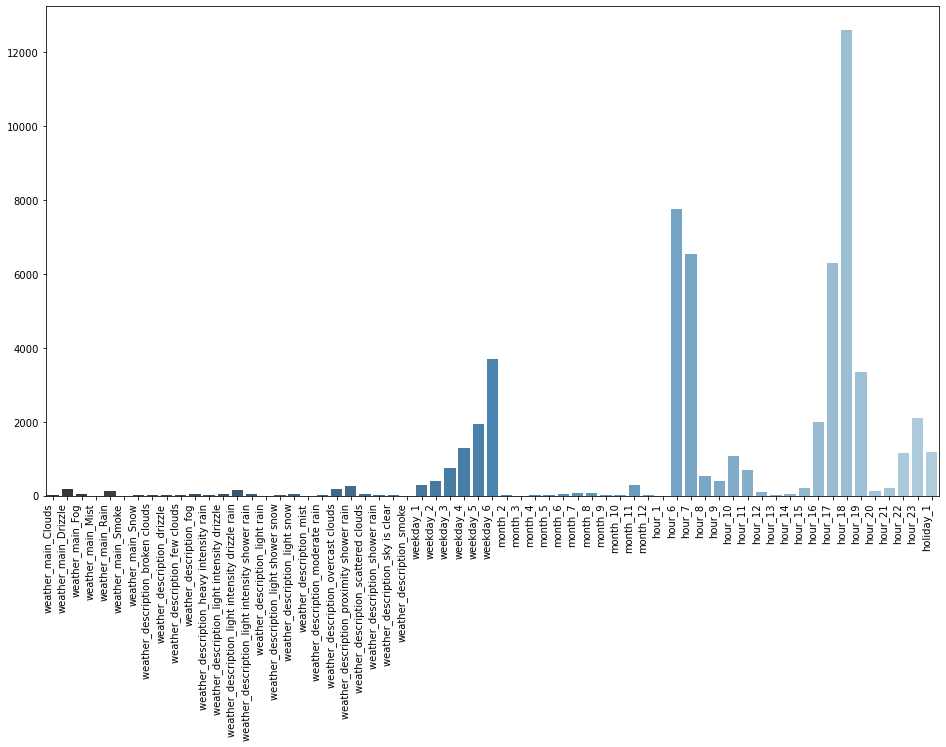

In [15]:
plt.figure(figsize=(16,9))
ax = sns.barplot(x=dummy_columns, y=fs.scores_,palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

In [16]:
#calculate correlation for numerical features
numeric=X_train.columns[(X_train.dtypes=="int64") | (X_train.dtypes=="float64")]
corr=pd.concat([X_train[numeric], y], axis=1).corr()

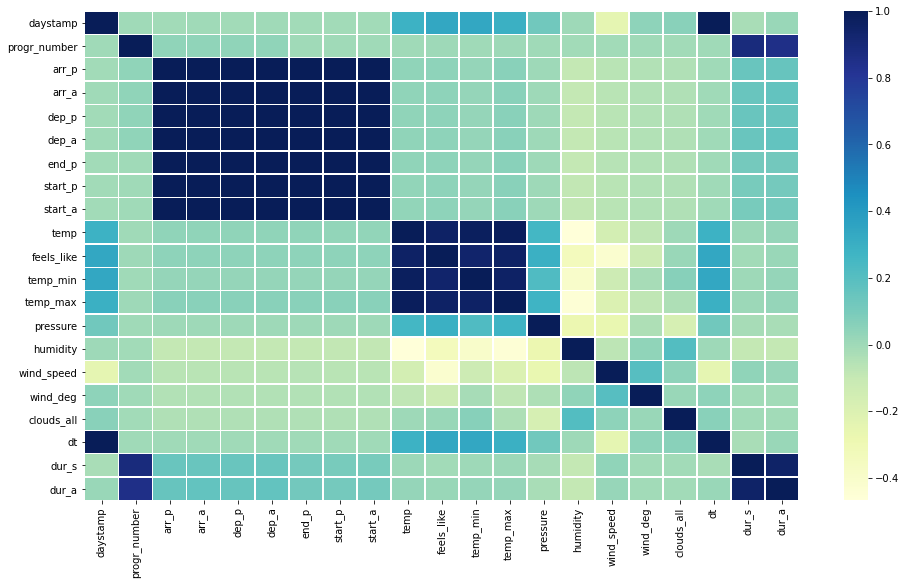

In [17]:
plt.figure(figsize=(16,9))
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidth=.5,cmap="YlGnBu")
plt.show()

In [18]:
#assemble dataframe for modelling
high_corr=corr["dur_a"][(corr["dur_a"]>=0.5) | (corr["dur_a"]<=-0.5)]
numeric=high_corr.drop(["dur_a"]).index
X=pd.concat([pd.get_dummies(X[categorical].drop(["weather_main"],axis=1),drop_first=True),df_clean[numeric]],axis=1)
y=df_clean["dur_a"]
X=X.reset_index(drop=True)
y=y.reset_index(drop=True)

<h2>Modelling Evaluation</h2>

In [19]:
#calculating benchmark
kf=KFold(n_splits=5,shuffle=True) 
r_2=[]
mse=[]
rmse=[]
mae=[]
for train_index,test_index in kf.split(X):
        X_test=X["dur_s"].values[test_index]
        y_test=y.values[test_index]
        r_2.append(metrics.r2_score(y_pred=X_test, y_true=y_test))
        curr_mse=metrics.mean_squared_error(y_pred=X_test, y_true=y_test)
        mse.append(curr_mse)
        rmse.append(curr_mse**(1/2))
        mae.append(metrics.mean_absolute_error(y_pred=X_test, y_true=y_test))
logs["modelling"]={
    "Benchmark":{
        "r_2":sum(r_2)/len(r_2),
        "mse":sum(mse)/len(mse),
        "rmse":sum(rmse)/len(rmse),
        "mae":sum(mae)/len(mae)
    }     
}

In [20]:
#define cross validation function for the models
def cross_val(model):
    start=time.time()
    r_2=[]
    mse=[]
    rmse=[]
    mae=[]
    for train_index,test_index in kf.split(X):
        X_train,X_test=X.values[train_index],X.values[test_index]
        y_train,y_test=y.values[train_index],y.values[test_index]
        model.fit(X_train,y_train)
        r_2.append(metrics.r2_score(y_pred=model.predict(X_test), y_true=y_test))
        curr_mse=metrics.mean_squared_error(y_pred=model.predict(X_test), y_true=y_test)
        mse.append(curr_mse)
        rmse.append(curr_mse**(1/2))
        mae.append(metrics.mean_absolute_error(y_pred=model.predict(X_test), y_true=y_test))
        print(f"Iteration done after {time.time()-start} secs.")
    cv_time=time.time()-start
    return {
        "time":cv_time,
        "r_2":sum(r_2)/len(r_2),
        "mse":sum(mse)/len(mse),
        "rmse":sum(rmse)/len(rmse),
        "mae":sum(mae)/len(mae)
    }

In [21]:
mlp=MLPRegressor(max_iter=100,hidden_layer_sizes=(50,100,50))
logs["modelling"]["Multi-layer Perceptron"]=cross_val(mlp)

c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration done after 1408.270269393921 secs.


c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration done after 2613.796504497528 secs.


c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration done after 3877.0829725265503 secs.


c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration done after 5107.330980062485 secs.


c:\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration done after 6335.479747772217 secs.


In [22]:
rfr_reg=RandomForestRegressor()
logs["modelling"]["Random Forest Regression"]=cross_val(rfr_reg)

Iteration done after 422.0538990497589 secs.
Iteration done after 847.0923688411713 secs.
Iteration done after 1267.8529841899872 secs.
Iteration done after 1684.4786496162415 secs.
Iteration done after 2107.94095993042 secs.


In [24]:
poly_reg=make_pipeline(PolynomialFeatures(2),LinearRegression())
pol_results=cross_val(poly_reg)

Iteration done after 146.64400506019592 secs.
Iteration done after 357.2078218460083 secs.
Iteration done after 542.7884814739227 secs.
Iteration done after 745.6083996295929 secs.
Iteration done after 924.3188495635986 secs.


In [25]:
pol_results

{'time': 924.338849067688,
 'r_2': 0.9315503007999457,
 'mse': 51405.67527668731,
 'rmse': 226.7259552972901,
 'mae': 164.60687477336373}

In [21]:
xgb_reg=xgb.XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=200)
logs["modelling"]["XGBoost"]=cross_val(xgb_reg)

Iteration done after 112.70116233825684 secs.
Iteration done after 225.3616237640381 secs.
Iteration done after 339.94807410240173 secs.
Iteration done after 455.7542998790741 secs.
Iteration done after 568.4863662719727 secs.


In [22]:
logs["modelling"]["XGBoost"]

{'time': 568.4873654842377,
 'r_2': 0.9377784667644985,
 'mse': 46728.60549897342,
 'rmse': 216.1671538184989,
 'mae': 153.90779865464583}

In [32]:
logs["modelling"]

{'Benchmark': {'r_2': 0.8715217272412099,
  'mse': 96486.22869596034,
  'rmse': 310.6209624153072,
  'mae': 219.44017410900437},
 'Multi-layer Perceptron': {'time': 6335.480748176575,
  'r_2': 0.936330036808428,
  'mse': 47815.630629905965,
  'rmse': 218.62950395175835,
  'mae': 154.82256130762076},
 'Random Forest Regression': {'time': 2107.9419610500336,
  'r_2': 0.9276185281596103,
  'mse': 54358.55379444116,
  'rmse': 233.148091469369,
  'mae': 165.19491608214716},
 'Polynomial Regression': {'time': 885.4161512851715,
  'r_2': 0.9315644746778828,
  'mse': 51394.61009096293,
  'rmse': 226.70319662263063,
  'mae': 164.59359547831082},
 'XGBoost': {'time': 885.4161512851715,
  'r_2': 0.9315644746778828,
  'mse': 51394.61009096293,
  'rmse': 226.70319662263063,
  'mae': 164.59359547831082}}

In [33]:
logs

{'rows': {'start': 614114,
  'route_filter': 0,
  'nan_filter': -17943,
  'negative_dur': -1060,
  'outliers': -5200},
 'scr': 0.9868873742291464,
 'stats': {1: {'dur_mean': 0.0, 'dur_std': 0.0},
  2: {'dur_mean': 91.23763745308487, 'dur_std': 78.81209674496715},
  3: {'dur_mean': 154.90575985237908, 'dur_std': 94.20358824096739},
  4: {'dur_mean': 205.5610859728507, 'dur_std': 110.37639009937962},
  5: {'dur_mean': 247.9658315844701, 'dur_std': 122.0267481508274},
  6: {'dur_mean': 345.35794743429284, 'dur_std': 147.78585594356608},
  7: {'dur_mean': 690.2152431011826, 'dur_std': 254.54645150997314},
  8: {'dur_mean': 811.4497962938625, 'dur_std': 287.1087495418867},
  9: {'dur_mean': 924.2014714576627, 'dur_std': 303.83657943186597},
  10: {'dur_mean': 1063.4412846446867, 'dur_std': 308.13416927230656},
  11: {'dur_mean': 1204.5778914240755, 'dur_std': 330.95258566363344},
  12: {'dur_mean': 1266.5328534031414, 'dur_std': 347.8359590503947},
  13: {'dur_mean': 1308.9253614181985, 'du